### TagRank for product data
Inspired from [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf), the TagRank method a novel method which applies graph-based method for keyword extraction. 

#### Reasons for using Graph-based model
The target of this task is to find high-level words that are descriptive of the product.
Graph-based model can:

1) Identify general words, as such words has more connections in the graph.

2) Identify general words that are descriptive of the product by looking at neighbour nodes in the graph.

It is able to identify the semantic relationship between words rather than just choosing words from the product names.

#### Data Format

|product_name|category|query|event|date|
|------------|--------|-----|-----|----|
|--- X 10 --- 七色 多層次搭配 圓下擺 LAYERED 素面 無袖背心 打底|Male Fashion|無袖|Impression|31/7/17|

#### Preprocess
##### 1.Clean up data
- Download "Product Keyword Extraction - Data" as "data.csv"
- Remove duplicate records
- Remove "event" entries from the data
- Remove wrong product names (#NAME? and #ERROR!)

##### 2.Text preprocessing (preprocessing/preprocess.py)
- preprocess the data to remove punctuations.
- Tokenize the text using jieba, and keep only ['ns', 'n', 'vn', 'v','eng'] tags.

#### TagRank
##### 1. Construct a graph based on the tokens
Each token in text is considered as a node in the graph. The connectivity of the graph consists the following cases:
- Two tokens are connected if they appear in the same product name (edge weight = 1.), and
- tokens in the product name are connected to tokens in the query (If event == "Impression", edge weight = 2. If event == "Click", edge weight = 3.) Note: the token in product name point to tokens in the query.

##### 2. Run page rank over the graph
The page rank algorithm will give the scores (the importance) of each node.

##### 3. Find important word for a given text
The TagRank algorithm will run over the neighbours of every node to find the representative tokens for the given text.

Suppose the $t_i$ stands for the $i^{th}$ token of a given text. The importance of neighbours of $t_i$ are:

$$n_i^j = (1-d) + d* \frac{w(i,j)} {\sum_{k}w(i,k)},$$
where $n_i^j$ is the $j^{th}$ neighbour of $t_i$, and $d$ is the damping factor.

The TagRank algorithm sum all the tag scores and ranks nodes in the graph according to the score.

In [1]:
import pandas as pd
import numpy as np
from preprocessing.preprocess import preprocess, tokenize
import networkx as nx
import operator
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.cross_validation import train_test_split

# load data and preprocess
product_log = pd.read_csv("data.csv",sep="\t",names=["product_name", "category", "query", "event", "date"])

print product_log.shape, product_log.drop_duplicates().shape
product_log = product_log.drop_duplicates()
product_log = product_log[product_log.event!= "Event"]
product_log = product_log[(product_log.product_name!="#NAME?") & (product_log.product_name!="#ERROR!")]
product_log.head(5)

(10317, 5) (10310, 5)


/Users/rren/workspace/x/keyword_extraction/virtenv/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,product_name,category,query,event,date
0,--- X 10 --- 七色 多層次搭配 圓下擺 LAYERED 素面 無袖背心 打底,Male Fashion,無袖,Impression,31/7/17
1,︱IBIT︱Gymshark 熱銷款 運動T恤 健身T恤 圓領短T 運動短T 健身鯊魚,Male Fashion,gymshark,Impression,31/7/17
2,︱IBIT︱Gymshark 超高彈性 短褲 運動短褲 跑步短褲 深蹲褲 訓練短褲,Male Fashion,gymshark,Impression,31/7/17
3,::另類情侶兄弟姊妹殼::電力滿格/不足黑白趣味浮雕手機軟殼i5/i5s/i5se/i6/i...,Mobile & Gadgets,軟殼,Click,31/7/17
4,：新舊手機商場：Iphone6 16金 （需要看細圖密我）,Mobile & Gadgets,iphone6 系列,Impression,30/7/17


In [2]:
# preprocess the data
product_log["query"] = product_log["query"].map(preprocess)
product_log.product_name = product_log.product_name.map(preprocess)

# tokenize
%time titles = product_log.product_name.map(lambda x: list(tokenize(x)))
%time keywords = product_log['query'].map(lambda x: list(tokenize(x)))
product_log["query_tokens"] = keywords
product_log["title_tokens"] = titles

Building prefix dict from /Users/rren/workspace/x/keyword_extraction/virtenv/lib/python2.7/site-packages/jieba/dict.txt ...
Loading model from cache /var/folders/dg/j9x86cjs0_v8qks12vvzcr400000gp/T/jieba.cache
Loading model cost 0.367121934891 seconds.
Prefix dict has been built succesfully.


CPU times: user 12min 3s, sys: 2.38 s, total: 12min 5s
Wall time: 12min 7s
CPU times: user 1min 21s, sys: 175 ms, total: 1min 21s
Wall time: 1min 21s


In [3]:
product_log[["event","query_tokens","title_tokens"]]

,event,query_tokens,title_tokens
0,Impression,[無袖],"[七色, 搭配, 圓下, 擺, layered, 素面, 無袖, 背心, 打底]"
1,Impression,[gymshark],"[ibit, gymshark, 熱銷款, 運動, t, 恤, 健身, t, 恤, 圓領, ..."
2,Impression,[gymshark],"[ibit, gymshark, 超高, 彈性, 褲, 運動, 短褲, 跑步, 褲, 蹲, ..."
3,Click,[軟殼],"[情侶, 兄弟, 姊妹, 殼, 電力, 滿格, 趣味, 浮雕, 手機, 軟殼, i5i5si..."
4,Impression,[iphone6],"[手機, 商場, iphone6, 需要, 看, 圖密]"
5,Impression,[iphone],"[手機, 商場, iphone7, g, 需要, 圖密]"
6,Click,[iphone7],"[手機, 商場, iphone7, g, 需要, 圖密]"
7,Impression,"[男生, 衣著]","[免運, 現貨, gildan, 典素, t, 買, 會]"
8,Impression,"[t, 恤]","[免運, 現貨, gildan, 典素, t, 買, 會]"
9,Click,"[休閒, 短褲]","[免運, 現貨, 大量, 現貨, 帶, 休, 閒, 色, m5xl]"


In [16]:
product_log_train, product_log_test = train_test_split(product_log,test_size=0.2)
product_log_train.shape, product_log_test.shape

((8236, 7), (2060, 7))

In [22]:
class TagRank(object):
    """
    Construct the TagRank graph for given data
    """
    def __init__(self,damping_factor=0.85):
        self.graph = None
        self.damping_factor = damping_factor
        
    def _vectorize(self,tokens):
        """
        Vectorize a list of tokens
        
        Inputs:
            @tokens: a list of tokens to vectorizer
        
        Output:
            A scipy sparse matrix of shape (vocabulary_size,1)
        """
        data = []
        row = []
        col = []
        for w in tokens:
            data.append(1.)
            row.append(self.vocab[w])
            col.append(0)
        return csr_matrix((data,(row,col)),shape=(len(self.vocab),1))
    
    def _query_title_vec(self,query,title,event):
        """
        Construct the cooccurrence matrix for product_name to query. 
        The edge weight from product_name to query is either 1.5 or 2.
        The edge weight from query to product_name is 1.
        
        Inputs:
            @query: the tokens of a user query
            @title: the tokens of a product name
            @event: event type. The value can be "Impression" or "Click"
            
        Output:
            The co-occurrence matrix in scipy sparse format
        """
        data = []
        row = []
        col = []
        if event == "Impression": val = 1.2
        else: val = 1.5
            
        for wt in title:
            for wq in query:
                data.append(val)
                row.append(self.vocab[wt])
                col.append(self.vocab[wq])
                
                data.append(1.)
                row.append(self.vocab[wq])
                col.append(self.vocab[wt])
        return csr_matrix((data,(row,col)),shape=(len(self.vocab),len(self.vocab)))
        
        
        
    def _construct_sparse_matrix(self,events,queries,titles):
        """
        Construct the cooccurrence matrix for a given record. 
        The co-occurrence matrix is added up by two elements: 
        1)The co-occurrence matrix of a given product name, and 
        2)The co-occurrence matrix from product_name to query.
        
        Inputs:
            @query: the tokens of a user query
            @title: the tokens of a product name
            @event: event type. The value can be "Impression" or "Click"
            
        Output:
            The co-occurrence matrix in scipy sparse format 
        """
        # construct vocabulary
        vocab = set([w for sentence in (queries + titles) for w in sentence])
        vocab = {w:i for (w,i) in zip(vocab,range(len(vocab)))}
        self.vocab = vocab
        self.i2w = {i:w for w,i in vocab.iteritems()}
        self.coo_matrix = csr_matrix(([],([],[])),shape=(len(self.vocab), len(self.vocab)))
        
        # construct sparse matrix
        row = []
        col = []
        data = []
        for e,q,t in zip(events,queries,titles):
            vec = self._vectorize(t)
            coo_matrix = (vec * vec.T) / len(self.vocab)
            self.coo_matrix += coo_matrix
            
            self.coo_matrix += self._query_title_vec(q,t,e)
        self.coo_matrix /= len(titles)
        
        
    def build_graph(self,events,queries,titles):
        """
        Build the TagRank graph.
        
        Inputs:
            @events: list of events
            @queries: list of tokenized queries
            @titles: list of tokenized product names
        """
        self._construct_sparse_matrix(events,queries,titles)
        self.graph = nx.from_scipy_sparse_matrix(self.coo_matrix)
        self.scores = nx.pagerank(self.graph)
        
    def get_ranking(self,tokens,topK=5):
        """
        Get top ranked tokens from the TagRank graph for a given list of tokens.
        
        Inputs:
            @tokens: list of tokens for a product name
            @topK: top K nodes to retrieve from the graph. Default=5
            
        Output:
            Top K nodes and related score from the graph
            [(node,aggregated_score)]
        """
        rankings = {i:0. for i in range(len(self.vocab))}
        for w in tokens:
            try:
                i = self.vocab[w]
                rank_sum = sum(self.scores[n] for n in self.graph.neighbors(i))
                for n in self.graph.neighbors(i):
                    rankings[n] += (1-self.damping_factor) + self.damping_factor * (self.scores[n] / rank_sum)
            except:
                pass
        
        rankings = sorted(rankings.items(), key=operator.itemgetter(1),reverse=True)
        results = [(self.i2w[i],score) for i,score in rankings[:topK]]
        return results

In [23]:
# build TagRank model for training data
tagrank = TagRank()
%time scores = tagrank.build_graph(product_log_train.event, product_log_train.query_tokens, product_log_train.title_tokens)

CPU times: user 53.4 s, sys: 7.77 s, total: 1min 1s
Wall time: 1min 1s


### Evaluation of the model 

In [53]:
%time predicted_tags = [np.array(tagrank.get_ranking(title))[:,0] for title in product_log_test.title_tokens]
def calculate_nhits(pred_tags,true_tags):
    """
    Find number of hits of the predicted results
    """
    return len(set(pred_tags).intersection(true_tags))
n_hits = map(lambda (p,t): calculate_nhits(p,t), zip(predicted_tags, product_log_test.query_tokens.values))

CPU times: user 1min 46s, sys: 963 ms, total: 1min 47s
Wall time: 1min 47s


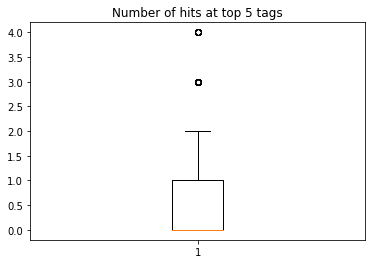

In [57]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

plt.boxplot(n_hits)
plt.title("Number of hits at top 5 tags")

In [62]:
print "average number of hits at Top 5: ", np.average(n_hits)

average number of hits at Top 5:  0.666019417476


##### Print some results for test data

In [67]:
def print_ranking(i):
    print 
    print test_data.product_name.iloc[i]
    print "-------------------------------"
    rankings = tagrank.get_ranking(test_data.title_tokens.iloc[i])

    for w,score in rankings:
        print w,score
    print "----------END------------------"

In [59]:
tagrank = TagRank()
%time scores = tagrank.build_graph(product_log.event, product_log.query_tokens, product_log.title_tokens)

CPU times: user 1min 12s, sys: 11.6 s, total: 1min 24s
Wall time: 1min 24s


In [84]:
# load test data
test_data = pd.read_csv("test.csv",sep="\t")
test_data["product_name"] = test_data["Product Name"].map(preprocess)

# tokenize
%time titles = test_data.product_name.map(lambda x: list(tokenize(x)))
test_data["title_tokens"] = titles
test_data.head(5)

CPU times: user 12.9 s, sys: 83.6 ms, total: 13 s
Wall time: 13 s


,Product Name,Category,product_name,title_tokens
0,寬鬆顯瘦大碼運動套裝T恤女夏季胖mm短袖短褲時尚休閒服兩件套,Female Clothes,寬鬆顯瘦大碼運動套裝t恤女夏季胖mm短袖短褲時尚休閒服兩件套,"[顯, 碼, 運, 動, 裝, t, 恤女, 胖, mm, 休, 閒服, 件套]"
1,♬【現貨實拍】夏季新款 2017韓版熱銷淑女夏裝間約氣質條紋背心吊帶連體褲顯瘦闊腿褲,Female Clothes,♬【現貨實拍】夏季新款 2017韓版熱銷淑女夏裝間約氣質條紋背心吊帶連體褲顯瘦闊腿褲,"[現貨, 實拍, 新款, 版, 熱銷, 淑女, 裝間, 氣質, 條紋, 背心, 吊帶, 體褲..."
2,新款時尚大碼女士服裝韓版印花短袖 t恤女夏寬鬆顯瘦,Female Clothes,新款時尚大碼女士服裝韓版印花短袖 t恤女夏寬鬆顯瘦,"[新款, 時尚, 大碼, 女士, 服裝, 印花, t, 恤女, 顯]"
3,a la sha 粉紅色阿財長版上衣,Female Clothes,a la sha 粉紅色阿財長版上衣,"[la, sha, 粉紅色, 上衣]"
4,女人的店~上班短裙.包臀裙.西裝裙(垂性很好.不易皺.不起球.不沾毛) 350元,Female Clothes,女人的店上班短裙包臀裙西裝裙垂性很好不易皺不起球不沾毛 350元,"[女人, 店, 上班, 短裙, 包, 裝裙, 垂性, 皺, 起球, 沾]"


In [85]:
# Sample results
for i in np.random.choice(range(test_data.shape[0]),replace=False,size=10):
    print_ranking(i)


現貨32c🍒新款維多利亞的秘密pink熱帶印花前釦蕾絲pushup集中內衣蕾絲內褲成套內衣褲🍒櫻桃娜娜美國代購🍒
-------------------------------
手機 2.65809208753
褲 2.54510839074
裝 2.23296110364
殼 2.22297259147
韓國 2.16319842017
----------END------------------

現貨供應【ucase】iphone7 i6 plus 超薄邊框保護套 矽膠 透明 防摔 手機殼 超薄邊框防刮背板
-------------------------------
手機 4.70476193542
殼 4.41487567892
保護 3.01781510121
現貨 2.99662072969
plus 2.98594676575
----------END------------------

mika🌸雪紡粉色暈染套裝🌸上衣短褲💕
-------------------------------
上衣 1.28845868313
氣質 0.788535736191
開叉 0.771600629223
褲 0.770328288221
套裝 0.763862706729
----------END------------------

衝評特賣！當天現貨寄出！ 團體服 圓領短袖t恤 短褲 短袖套裝 吸汗打底衫 休閒印花t恤 情侶潮t 大尺碼 t恤 沙灘褲
-------------------------------
褲 4.98219288227
t 4.64426779155
運動 4.20523919832
外套 4.17341047029
恤 4.07920115344
----------END------------------

oeo airbeats bts01 防水防塵藍牙攜帶重低音藍芽喇叭 iphone6s plus i6 i6s 紅米 小米note zenfone2 m320 z3 z5 c4 c5 816
-------------------------------
手機 7.83989193637
plus 3.81893699807
殼 3.63754015233
小米 3.4892973366
帶 3.301924

In [86]:
keywords = []
for title in test_data.title_tokens:
    ws = tagrank.get_ranking(title,topK=5)
    keywords.append(" ".join([w[0] for w in ws]))
test_data["Keywords"] = keywords

In [92]:
test_data.drop(["product_name", "title_tokens"],axis=1).to_csv("results.csv",sep="\t",index=False,encoding="UTF-8")

### Future Work
- Use TFIDF to lower the importance of repeated words.
- Include window size for computing co-occurrence matrix.
- Include customized words for jieba tokenizer ("褲" etc.).